In [2]:

import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import numpy as np
from torchvision.transforms import functional as TF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
class VOCDataset(Dataset):
    def __init__(self, root_dir, year='2012', image_set='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_dir = os.path.join(root_dir, 'VOCdevkit', 'VOC' + year, 'JPEGImages')

        # Load image ids from the corresponding split text file
        split_file = os.path.join(root_dir, 'VOCdevkit', 'VOC' + year, 'ImageSets', 'Main', image_set + '.txt')
        with open(split_file, 'r') as file:
            self.image_ids = file.read().split()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, img_id + '.jpg')
        image = Image.open(img_path).convert('RGB')
       
        if self.transform:
            image = self.transform(image)
       
        image_np = np.array(image)
        image_lab = rgb2lab(image_np).astype("float32")  # Convert to LAB space
        image_lab = transforms.ToTensor()(image_lab)  # Convert to tensor
        
        l_channel = image_lab[0, :, :].unsqueeze(0)
        ab_channels = image_lab[1:, :, :]

        return l_channel, ab_channels

    
def rgb2lab(image):
    from skimage.color import rgb2lab
    return rgb2lab(image)

In [4]:
from torch.utils.data import random_split

class PatchShuffleTransform:
    def __init__(self, patch_size):
        self.patch_size = patch_size

    def __call__(self, img):
        img = img.copy()
        width, height = img.size
        patches = []

        for i in range(0, width, self.patch_size):
            for j in range(0, height, self.patch_size):
                box = (i, j, min(i + self.patch_size, width), min(j + self.patch_size, height))
                patch = img.crop(box)
                patches.append((box, patch))
        
       
        random.shuffle(patches)

        for (box, patch) in patches:
            img.paste(patch, box)

        return img

patch_size = 2

train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BICUBIC),
    PatchShuffleTransform(patch_size),  
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BICUBIC),
])



dataset_root = '/kaggle/input/vocdevkit' 
# voc_dataset = VOCDataset(root_dir=dataset_root, transform=transform)
# dataloader = DataLoader(voc_dataset, batch_size=16, shuffle=True)

full_dataset = VOCDataset(root_dir=dataset_root, transform=None)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.encoder1 = self.conv_block(1, 32)
        self.encoder2 = self.conv_block(32, 64)
        self.encoder3 = self.conv_block(64, 128)
        self.encoder4 = self.conv_block(128, 256)
        self.down = nn.MaxPool2d(2)
    
        # Bottleneck
        self.bottleneck = self.conv_block(256, 512, dropout=True)

        # Decoder (Upsampling and concatenation path)
        self.upconv4 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv4 = self.conv_block(512, 256, dropout=True)  # 256 from upconv + 256 from encoder
        self.upconv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = self.conv_block(256, 128, dropout=True)  # 128 from upconv + 128 from encoder
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv2 = self.conv_block(128, 64)  # 64 from upconv + 64 from encoder
        self.upconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv1 = self.conv_block(64, 32)  # 32 from upconv + 32 from encoder

        # Final layer
        self.final_conv = nn.Sequential(
            nn.Conv2d(32, 2, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        down1 = self.down(enc1)
        
        enc2 = self.encoder2(down1)
        down2 = self.down(enc2)
        
        enc3 = self.encoder3(down2)
        down3 = self.down(enc3)
        
        enc4 = self.encoder4(down3)
        down4 = self.down(enc4)
        
        bottleneck = self.bottleneck(down4)
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.conv4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.conv3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.conv2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.conv1(dec1)
        
        output = self.final_conv(dec1)
        return output

    def conv_block(self, in_channels, out_channels, dropout=False):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(0.3))
        return nn.Sequential(*layers)


model = UNet()
dummy_input = torch.randn(1, 1, 256, 256)  # Example input tensor
output = model(dummy_input)
print(output.shape)

torch.Size([1, 2, 256, 256])


In [6]:
!pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 7.2 MB/s eta 0:00:00


In [7]:
from piq import ssim
def gradient_loss(gen_frames, gt_frames):
    gen_frames_x = gen_frames[:, :, 1:, :] - gen_frames[:, :, :-1, :]
    gen_frames_y = gen_frames[:, :, :, 1:] - gen_frames[:, :, :, :-1]
    gt_frames_x = gt_frames[:, :, 1:, :] - gt_frames[:, :, :-1, :]
    gt_frames_y = gt_frames[:, :, :, 1:] - gt_frames[:, :, :, :-1]

    grad_loss = F.l1_loss(gen_frames_x, gt_frames_x) + F.l1_loss(gen_frames_y, gt_frames_y)
    return grad_loss

class CombinedLoss(torch.nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()

    def forward(self, outputs, targets):
        l1_loss = F.l1_loss(outputs, targets)
        ssim_loss = 1 - ssim(outputs, targets, data_range=1)
        grad_loss = gradient_loss(outputs, targets)
        return l1_loss + 0.25 * ssim_loss + 0.5 * grad_loss

In [8]:
model = UNet().to(device)
#criterion = nn.MSELoss()
criterion = CombinedLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for gray_images, ab_channels in train_loader:
        gray_images = gray_images.to(device)  
        ab_channels = ab_channels.to(device) 
        optimizer.zero_grad()
        outputs = model(gray_images)
        ab_channels = (ab_channels - ab_channels.min()) / (ab_channels.max() - ab_channels.min())
        loss = criterion(outputs, ab_channels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for gray_images, ab_channels in val_loader:
            gray_images = gray_images.to(device)  
            ab_channels = ab_channels.to(device)
            outputs = model(gray_images)
            ab_channels = (ab_channels - ab_channels.min()) / (ab_channels.max() - ab_channels.min())
            loss = criterion(outputs, ab_channels)
            val_loss += loss.item()
        print(f"Validation Loss: {val_loss / len(val_loader)}")

Epoch [1/5], Loss: 0.2103
Validation Loss: 0.1408668573324879
Epoch [2/5], Loss: 0.1357
Validation Loss: 0.13984270580112934
Epoch [3/5], Loss: 0.1351
Validation Loss: 0.13993779611256388
Epoch [4/5], Loss: 0.1353
Validation Loss: 0.13982522063371208
Epoch [5/5], Loss: 0.1360
Validation Loss: 0.13985848457862934


Train images:


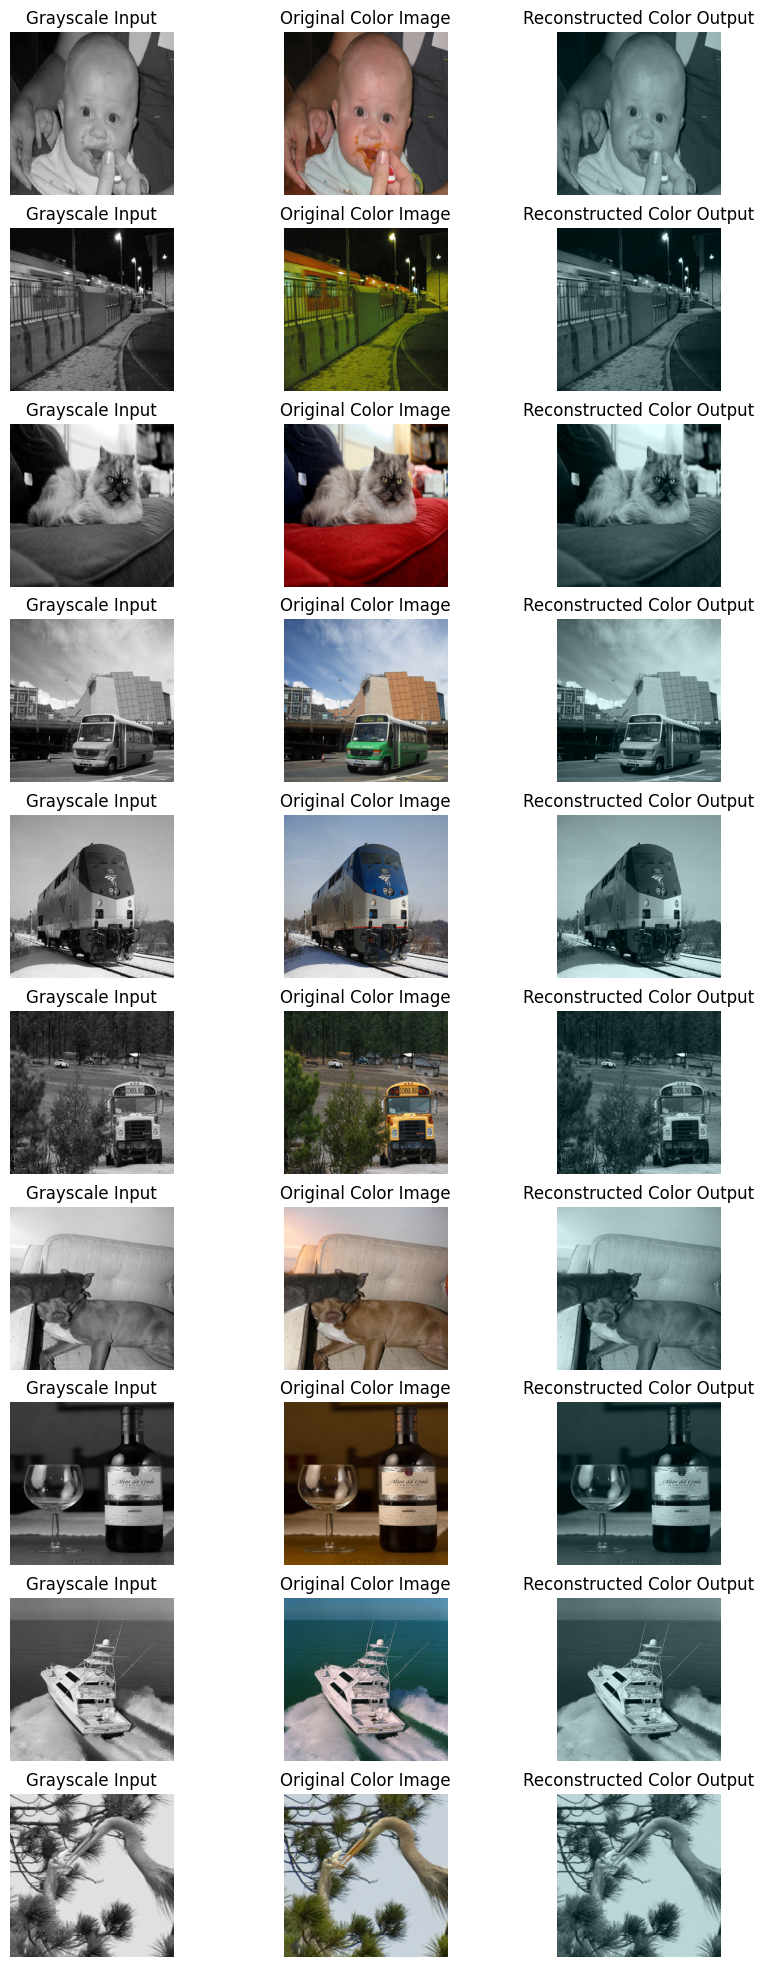

Validation images:


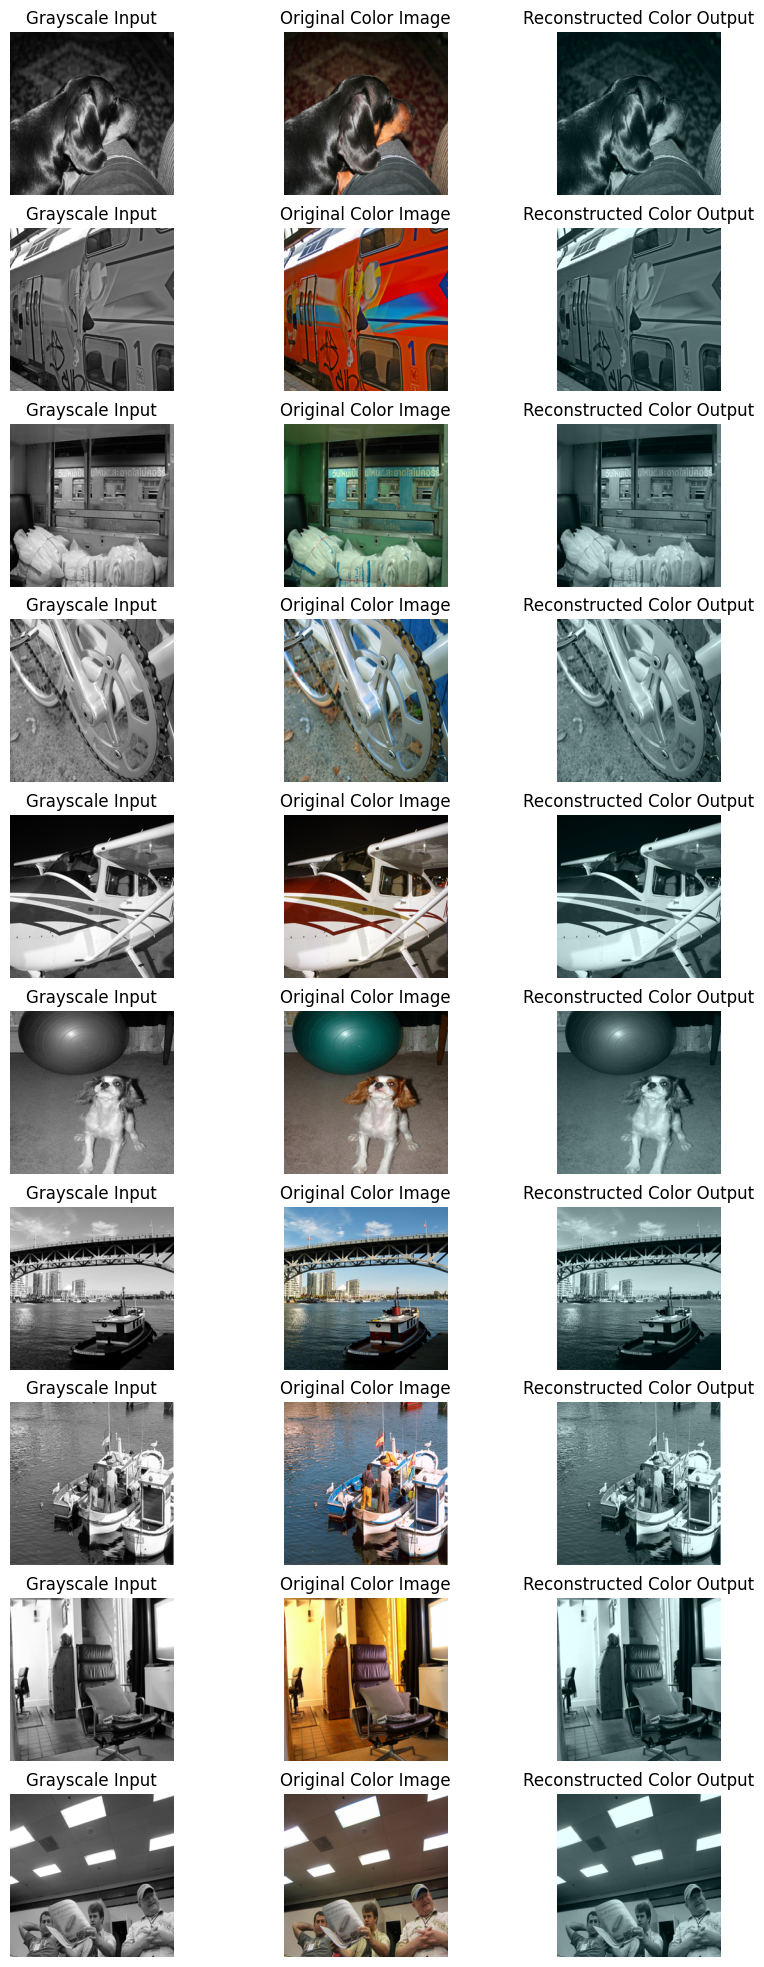

In [9]:
import torch
import matplotlib.pyplot as plt
from skimage.color import lab2rgb
import numpy as np

def visualize_results(data_loader, model, device, num_images=10):
    model.eval()
    images, color_targets = next(iter(data_loader))
    images, color_targets = images.to(device), color_targets.to(device)
    
    with torch.no_grad():
        outputs = model(images)  # This will give the predicted a and b channels

    l_images = images.cpu().squeeze(1)  # L channel
    ab_images = (outputs.cpu() - 0.5) * 2 * 128   # a and b channels predicted by the model

    fig, axs = plt.subplots(num_images, 3, figsize=(10, num_images * 2.5))
    for i in range(num_images):
        l_img = l_images[i].numpy()
        ab_img = ab_images[i].permute(1, 2, 0).numpy()
        
        # Combine L channel with predicted a and b channels
        lab_image = np.stack((l_img, ab_img[:, :, 0], ab_img[:, :, 1]), axis=2)
        
        # Convert LAB to RGB
        rgb_image = lab2rgb(lab_image)

        axs[i, 0].imshow(l_img, cmap='gray')  # Grayscale input
        axs[i, 1].imshow(lab2rgb(np.stack((l_img, color_targets[i][0].cpu(), color_targets[i][1].cpu()), axis=2)))  # Original Color Image
        axs[i, 2].imshow(rgb_image)  # Reconstructed Color Output
        
        axs[i, 0].set_title('Grayscale Input')
        axs[i, 1].set_title('Original Color Image')
        axs[i, 2].set_title('Reconstructed Color Output')
        
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')
        axs[i, 2].axis('off')
    plt.show()

print("Train images:")
visualize_results(train_loader, model, device)
print("Validation images:")
visualize_results(val_loader, model, device)

In [ ]:
import torch
import math

def mse_loss(output, target):
    return ((output - target) ** 2).mean()

def psnr_loss(output, target, max_val=1.0):
    mse = mse_loss(output, target)
    if mse == 0:  # Prevent division by zero
        return float('inf')
    return 20 * math.log10(max_val / math.sqrt(mse))


model.eval()
with torch.no_grad():
    total_psnr = 0
    for data in val_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        psnr = psnr_loss(outputs, labels)
        total_psnr += psnr
    average_psnr = total_psnr / len(val_loader)
    print(f'Average PSNR: {average_psnr:.2f} dB')

In [ ]:
torch.save(model, 'model.pth')
torch.save(model.state_dict(), 'model_state_dict.pth')